In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision
import matplotlib.pyplot as plt
from ema_pytorch import EMA
from torchinfo import summary
from ml_zoo.datamodules import MNISTDataModule
from ml_zoo.models.components import VectorQuantizer

In [2]:
dm = MNISTDataModule(
    data_dir="data",
    dataset_params={
        "download": True,
        "transform": torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize((32, 32)),
                torchvision.transforms.ToTensor(),
            ]
        ),
    },
    loader_params={
        "batch_size": 64,
    },
)
dm.prepare_data()
dm.setup()
trian_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

In [92]:
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv2d, self).__init__()
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.depthwise = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=out_channels,
        )
        self.norm1 = nn.GroupNorm(1, out_channels)
        self.norm2 = nn.GroupNorm(1, out_channels)
        self.act = nn.GELU()

    def forward(self, x):
        x = self.pointwise(x)
        x = self.act(x)
        x = self.norm1(x)
        x = self.depthwise(x)
        x = self.act(x)
        x = self.norm2(x)

        return x


class ConvStack(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        num_layers,
        kernel_size=3,
        stride=1,
        padding=1,
        conv_type=DepthwiseSeparableConv2d,
    ):
        super(ConvStack, self).__init__()
        self.layers = nn.ModuleList(
            [
                conv_type(in_channels, out_channels, kernel_size, stride, padding)
                if _ == 0
                else conv_type(out_channels, out_channels, kernel_size, stride, padding)
                for _ in range(num_layers)
            ]
        )

    def forward(self, x):
        x = self.layers[0](x)
        for layer in self.layers[1:]:
            residual = x
            x = layer(x) + residual
        return x


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.PixelUnshuffle(2),
            ConvStack(16 * 4, 16, 2),
            nn.PixelUnshuffle(2),
            ConvStack(16 * 4, 16, 2),
            nn.PixelUnshuffle(2),
            ConvStack(16 * 4, 16, 2),
        )

        # self.quantizer = VectorQuantizer(
        #     embedding_dim=256,
        #     num_embeddings=512,
        #     use_ema=True,
        #     decay=0.99,
        #     epsilon=1e-5,
        # )

        self.decoder = nn.Sequential(
            ConvStack(16, 16, 2),
            nn.PixelShuffle(2),
            ConvStack(4, 16, 2),
            nn.PixelShuffle(2),
            ConvStack(4, 16, 2),
            nn.PixelShuffle(2),
            nn.Conv2d(4, 1, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def quantizer(self, x):
        return x, None, None, None

    def forward(self, x):
        x = self.encoder(x)
        # print(x.shape)
        (z_emb, dict_loss, commit_loss, idxs) = self.quantizer(x)
        x = self.decoder(z_emb)
        return (x, z_emb, dict_loss, commit_loss, idxs)


model = Autoencoder().to("mps")
summary(
    model,
    input_data=torch.randn(1, 1, 32, 32, device="mps", requires_grad=False),
    depth=2,
)

Layer (type:depth-idx)                                  Output Shape              Param #
Autoencoder                                             [1, 1, 32, 32]            --
├─Sequential: 1-1                                       [1, 16, 4, 4]             --
│    └─Conv2d: 2-1                                      [1, 16, 32, 32]           160
│    └─PixelUnshuffle: 2-2                              [1, 64, 16, 16]           --
│    └─ConvStack: 2-3                                   [1, 16, 16, 16]           1,760
│    └─PixelUnshuffle: 2-4                              [1, 64, 8, 8]             --
│    └─ConvStack: 2-5                                   [1, 16, 8, 8]             1,760
│    └─PixelUnshuffle: 2-6                              [1, 64, 4, 4]             --
│    └─ConvStack: 2-7                                   [1, 16, 4, 4]             1,760
├─Sequential: 1-2                                       [1, 1, 32, 32]            --
│    └─ConvStack: 2-8                             

In [93]:
ema = EMA(model, beta=0.999, update_after_step=1000, update_every=100)
optimizer = torch.optim.Adam(model.parameters(), lr=6e-4)
criterion = F.binary_cross_entropy

In [94]:
test_loss = 0
for epoch in range(10):
    model.train()
    pbar = tqdm(trian_loader, desc=f"Epoch {epoch+1}")
    for img, _ in pbar:
        img = img.to("mps")
        optimizer.zero_grad()
        output = model(img)
        
        recon_error = criterion(output[0], img)
        loss = recon_error
        if output[2] is not None:
            loss += output[2]
        if output[3] is not None:
            loss += output[3]
            
        loss.backward()
        optimizer.step()

        ema.update()
        pbar.set_postfix({"loss": loss.item(), "test_loss": test_loss})

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for img, _ in tqdm(test_loader, desc="Testing", leave=True):
            img = img.to("mps")
            output = model(img)
            loss = criterion(output[0], img)
            if output[2] is not None:
                loss += output[2]
            if output[3] is not None:
                loss += output[3]
            test_loss += loss

    test_loss /= len(test_loader)
    test_loss = test_loss.item()

Epoch 3:   8%|▊         | 76/938 [00:04<00:54, 15.71it/s, loss=0.151, test_loss=0.135]


KeyboardInterrupt: 

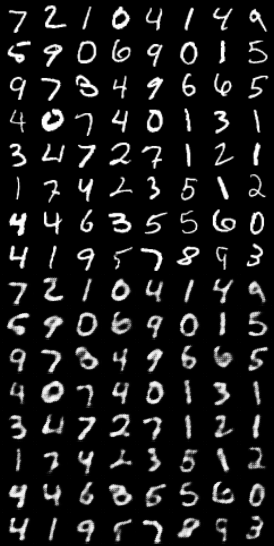

In [95]:
@torch.no_grad()
def plot_reconstructions(model):
    model.eval()
    img, _ = next(iter(test_loader))
    img = img.to("mps")
    output = model(img)
    display(
        torchvision.transforms.ToPILImage()(
            torchvision.utils.make_grid(
                torch.cat([img, output[0]], dim=0).to("cpu"), nrow=8
            ),
        )
    )


plot_reconstructions(model)

In [ ]:
from collections import Counter

@torch.no_grad()
def codebook_usage(model, loader):
    model.eval()
    counter = Counter()
    for img, _ in tqdm(loader, desc="Calculating codebook usage"):
        img = img.to("mps")
        output = model(img)
        idxs = output[4]
        counter.update(idxs.cpu().numpy().flatten())
    return counter

# plot codebook usage
usasge = codebook_usage(model, test_loader)
plt.figure(figsize=(20, 5))
plt.imshow(
    torch.tensor([usasge[i] for i in range(512)]).reshape(16, 32).numpy(),
    cmap="hot",
)
plt.colorbar()
plt.show()

In [ ]:
print(len(usasge))